**Calibration of spatial deterministic model** (focus on arrondissements)

Notes:
1. Based on calibration of national deterministic model found in ...
2. Includes Proximus mobility matrices that is updated every day
3. Includes three-fold stratified $\beta$ parameter (rural/urban/metropolitan)

NOTE: an updated version of this is found in `../hpc/mrollier-calibration-WAVE1_arr.py`.

# Load Python packages

In [88]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# diagnosis Notebook tool
import snakeviz

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility, sciensano
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
import covid19model.models.time_dependant_parameter_fncs as tdpf
# Had to import ALL functions, to avoid pickle error
# from covid19model.models.time_dependant_parameter_fncs import mobility_update_func
# from covid19model.models.time_dependant_parameter_fncs import google_lockdown, delayed_ramp_fun, contact_matrix

# Import date_to_YYYYMMD function
from covid19model.data.mobility import date_to_YYYYMMDD

# Functions for calibration (PSO first, MCMC later)
from covid19model.optimization import pso, objective_fcns

# Moving average for visualisation
from covid19model.visualization.utils import moving_avg

# Additional functions needed to simplify Notebook code
from covid19model.models.utils import read_pops, read_coordinates_nis, initial_state

# Download function for complete calibration
# covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'arr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model parameter values
The model is supported by many parameters, which must be loaded into the model later on

In [80]:
# Load interaction matrices. Data taken from willem2012. No CoMix data used yet!
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=agg)
# levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}

In [81]:
# Daily mobility reduction in 6 categories from Google compared to baseline (what baseline?)
df_google = mobility.get_google_mobility_data(update=False, plot=False)
df_google.tail(2)
# df_google.head()

,retail_recreation,grocery,parks,transport,work,residential
date,,,,,,
2021-04-23,-39.0,15.0,72.0,-24.0,-22.0,11.0
2021-04-24,-39.0,9.0,84.0,-22.0,-3.0,8.0


In [82]:
# Define the sloped functions defining the changes in interaction patterns. Copied from JV-calibration-COVID19-SEIRD-WAVE1-comix.ipynb
def policies_wave1_4prev(t, states, param, l , tau, prev_schools, prev_work, prev_rest, prev_home, df_google, Nc_all):

    contact_matrix_4prev = tdpf.make_contact_matrix_function(df_google, Nc_all)
    
    def all_contact(t):
        return Nc_all['total']

    def all_contact_no_schools(t):
        return Nc_all['total'] - Nc_all['schools']
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-09-01') # end of summer holidays

    if t <= t1:
        t = pd.Timestamp(t.date())
        return all_contact(t)
    elif t1 < t < t1 + tau_days:
        t = pd.Timestamp(t.date())
        return all_contact(t)
    elif t1 + tau_days < t <= t1 + tau_days + l_days:
        t = pd.Timestamp(t.date())
        policy_old = all_contact(t)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return tdpf.delayed_ramp_fun(policy_old, policy_new, t, tau_days, l, t1)
    elif t1 + tau_days + l_days < t <= t2:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t2 < t <= t3:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t3 < t <= t4:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)                     
    else:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)

In [ ]:
# # Define the sloped functions defining the changes in interaction patterns. Copied from JV-calibration-COVID19-SEIRD-WAVE1-comix.ipynb
# def wave1_policies(t, states, param, df_google, Nc_all, l , tau, 
#                    prev_schools, prev_work, prev_transport, prev_leisure, prev_others, prev_home):
    
#     # Convert tau and l to dates
#     tau_days = pd.Timedelta(tau, unit='D')
#     l_days = pd.Timedelta(l, unit='D')

#     # Define additional dates where intensity or school policy changes
#     t1 = pd.Timestamp('2020-03-15') # start of lockdown
#     t2 = pd.Timestamp('2020-05-18') # gradual re-opening of schools (15%)
#     t3 = pd.Timestamp('2020-06-04') # further re-opening of schools (65%)
#     t4 = pd.Timestamp('2020-07-01') # closing schools (end calibration wave1)

#     if t <= t1 + tau_days:
#         return tdpf.contact_matrix(t, df_google, Nc_all, school=1)
#     elif t1 + tau_days < t <= t1 + tau_days + l_days:
#         policy_old = tdpf.contact_matrix(t, df_google, Nc_all, school=1)
#         policy_new = tdpf.contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
#                                     prev_leisure, prev_others, school=0)
#         return tdpf.delayed_ramp_fun(policy_old, policy_new, t, tau_days, l, t1)
#     elif t1 + tau_days + l_days < t <= t2:
#         return tdpf.contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
#                               prev_leisure, prev_others, school=0)
#     elif t2 < t <= t3:
#         return tdpf.contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
#                               prev_leisure, prev_others, school=0.15)
#     elif t3 < t <= t4:
#         return tdpf.contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
#                               prev_leisure, prev_others, school=0.65)
#     else:
#         return tdpf.contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
#                               prev_leisure, prev_others, school=0)

In [86]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg)

# Add the social effect of the first lockdown (test values)
params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
               'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_home' : 0.5,
               'prev_rest' : 0.5
              })


# Add parameters for the daily update of proximus mobility
# all_mobility_data, average_mobility_data = tdpf.load_all_mobility_data(agg)
mobility_update_func = tdpf.make_mobility_update_function(agg, dtype='fractional', beyond_borders=False)
params.update({'default_mobility' : None,
               'mobility_update_func' : mobility_update_func}) # mobility defaults to average mobility of 2020 if no data is available
#                'agg' : agg})

# NOTE: the params updates below will have to be changed after the spatial vaccination update
# Add missing parameters for vaccination (not used now, but formally necessary) {'e', 'K', 'N_vacc', 'leakiness', 'v'}
params.update({'e' : np.zeros(initN.shape[1]),
               'K' : 1,
               'N_vacc' : np.zeros(initN.shape[1]),
               'leakiness' : np.zeros(initN.shape[1]),
               'v' : np.zeros(initN.shape[1]),
               'injection_day' : 500, # Doesn't really matter
               'injection_ratio' : 0})

# Remove superfluous parameters
params.pop('alpha')

# Add clearly distinct infectivity parameters for demonstration for SANITY CHECK. Comment out for default beta values
# beta_R = .01
# beta_U = .02
# beta_M = .03
# params.update({'beta_R' : beta_R,
#                'beta_U' : beta_U,
#                'beta_M' : beta_M})

TypeError: __init__() got an unexpected keyword argument 'dtype'

# Initialise model
The spatial model must have an initial condition. There are many choices, all included in the `initial_state` function. We choose the initial distribution to be only in Brussels, and the initial exposed individual is 40-50 years old. This is to some extent an arbitrary choice, but inspired by the idea that the first case is imported by plane (Brussels-Zaventem).

Other choices for initial conditions can be explored by inspection of the function description (`initial_state?`).

The simulation is run and plotted once for the default parameter values to demonstrate its effect.

**THIS IS WHERE THE ERROR USED TO OCCUR**

It has been fixed by removing `@lru_cache` from the function definition, and moving the mobility_dict to the model parameters.

In [6]:
%load_ext snakeviz

In [21]:
%%snakeviz
# Initial states: single 30 year old exposed individual in Brussels
initE = initial_state(dist='bxl', agg=agg, age=40, number=10) # 10 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and wave1_policies determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_wave1_4prev, 'place' : tdpf.mobility_wrapper_func}, spatial=agg)

# Temporal range of the simulation
# Note: lockdown date is defined inside the wave1_policies function
end_date = pd.to_datetime('2020-06-15') # end simulation before gradual reopening of schools (May 18th)
start_date = pd.to_datetime('2020-01-15')
out = model_wave1.sim(end_date, start_date=start_date)

 
*** Profile stats marshalled to file '/var/folders/w7/zdpn9hy13k9c360rk5fb5zf80000gn/T/tmp_33jrffu'. 
Embedding SnakeViz in this document...


In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,5))

place1=81000 # Arlon
place2=21000 # Brussels

infected(out.sel(place=place1), ax=ax1)
ax1.grid(False)
ax1.set_xlabel(None)
ax1.set_title(f"Evolution in {place1}.", fontsize=14)
ax1.set_ylabel(None)

infected(out.sel(place=place2), ax=ax2)
ax2.grid(False)
ax2.set_xlabel(None)
ax2.set_title(f"Evolution in {place2}.", fontsize=14)
ax2.get_legend().remove()
ax2.set_ylabel(None)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
# plt.savefig("test", dpi=200)

# Load and show all hospitalisation data per arrondissement
The model is calibrated on daily new hospitalisations (`H_in`). This data is found in the nonpublic repository. 7-day averaged data is available from March 5th 2020. This is almost two weeks prior to the first lockdown (March 18th). Mobility data is available for this date.

In [ ]:
nonpublic_ts = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values='hospitalised_IN', moving_avg=True)
nonpublic_ts.tail(2)

In [ ]:
# Show all 43 time series and one selection
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(16, 4))

nonpublic_ts.plot(ax=ax2, linewidth=0, kind='area')
ax2.legend().remove()
ax2.grid(False)
xlabel=ax2.set_xlabel(None)
title=ax2.set_title(f'Daily new hospitalisations per {agg} (7-day moving average)')
ylim=ax2.set_ylim([0, 600])

# Add data for one NIS
NIS_choice=21000
nonpublic_ts[[NIS_choice]].plot(ax=ax3)
# ax3.legend().remove()
ax3.grid(False)
# title=ax3.set_title(f'Daily new hospitalisations for NIS {NIS_choice} (7-day moving average)')

for ax in fig.get_axes():
    ax.label_outer()

# Calibration

The code below is mostly copied from `JV-calibration-COVID19-SEIRD-WAVE1.ipynb` and the functions used there.

In [ ]:
# Date of first data collection
start_calibration = '2020-03-05' # first available date
# Last datapoint used to calibrate prevention parameters
end_calibration = '2020-07-01'

# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: identifier
spatial_unit = f'{agg}_willem2012_prev_thin'

In [ ]:
# define dataset from the start and end date
data=[nonpublic_ts[start_calibration:end_calibration]]

# Define the compartment that the calibration will be looking at
states = [["H_in"]]

In [ ]:
# Initial value for warmup time
init_warmup = 30

# Parameters for PSO
maxiter = 100
popsize = 5

# Number of parallel processors used
processes = 4

# Parameters for MCMC
steps_mcmc = 3000 #3000
discard = 1000 #1000

In [ ]:
############################################################
####### CALIBRATING WARMUP, BETA AND COMPLIANCE RAMP #######
############################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['warmup', 'beta_R', 'beta_U', 'beta_M', 'l', 'tau']
bounds=((10,80), (0.010,0.060), (0.010,0.060), (0.010,0.060), (0.1,20), (0.1,20))

# run PSO optimisation
# theta_pso = pso.fit_pso(model_wave1,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
#                     start_date=start_calibration,warmup=init_warmup, processes=processes, dist='poisson', poisson_offset=1, agg=agg) 
# warmup = int(theta_pso[-1])

# Scratches

## Only show upper graph of H_in timeseries

In [ ]:
# Show all 43 time series and one selection
fig, ax69 = plt.subplots(figsize=(12, 7))

nonpublic_ts.plot(ax=ax69, linewidth=0, kind='area')
ax69.legend().remove()
ax69.grid(False)
xlabel=ax69.set_xlabel(None)
ylabel=ax69.set_ylabel(r'$H_{in}$',size=18)
title=ax69.set_title(f'Daily new hospitalisations per arrondissement (7-day moving average)', size=18)
ylim=ax69.set_ylim([0, 650])

plt.savefig("daily-new-hosp_arr_until-31032021", dpi=400, bbox_inches='tight')

## Plot preliminary results from PSO

In [ ]:
# Fill in data from PSO (ran from console)
#initial conditions
initE = initial_state(dist='bxl', agg=agg, age=40, number=1) # 1 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE}
#parameters
params.update({"beta_R": 0.05911714228791011, # taken from corner plot
               "beta_U": 0.05807289680441654, # taken from corner plot
               "beta_M": 0.05370565085646678, # taken from corner plot
               "l": 12.93255574616446, # taken from corner plot
               "tau": 0.1}) # fixed
warmup=35 # taken from PSO
start_calibration = '2020-03-05'

# Execute simulation with these data
#initiate model with initial states, defined parameters, and wave1_policies determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : tdpf.wave1_policies, 'place' : tdpf.mobility_update_func}, spatial=agg)
#simulate
out = model_wave1.sim(end_date, start_date=start_calibration, warmup=warmup)#, N=2)

In [ ]:
# sum total
fig, ax = plt.subplots(figsize=(16,5))

out["H_in"].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='simulation')
nonpublic_ts.sum(axis=1).plot(ax=ax, label='data', style='.')
plt.plot()
ax.grid(False)
ax.legend()
title=ax.set_title("Comparison between preliminary PSO results and Sciensano data. Summed over all NIS codes.")

In [ ]:
# Individual
NIS=11000

fig, ax = plt.subplots(figsize=(16,5))

out["H_in"].sum(dim='Nc').sel(place=NIS).plot(ax=ax, label='simulation')
nonpublic_ts[[NIS]].plot(ax=ax, label='data', style='.')
plt.plot()
ax.grid(False)
ax.legend()
title=ax.set_title("Comparison between preliminary PSO results and Sciensano data. For one NIS code.")

In [ ]:
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_sciensano.index, df_sciensano[[32000]], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)

## Test the relation between length of `l` and execution time
I suspect that low `l` values imply that the discontinuity is 'stronger', meaning that the ODE solver needs more time steps

In [ ]:
# Fill in data from PSO (ran from console)
#initial conditions
initE = initial_state(dist='bxl', agg=agg, age=40, number=1) # 1 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE}

import time

lrange = list(np.arange(1,20,1))
times = np.array([])

for l in np.arange(1, 20, 1):
    start_time = time.time()
    # execute code
    params.update({"beta_R": 0.0502,
                   "beta_U": 0.0350,
                   "beta_M": 0.035,
                   "l": l, #
                   "tau": 0.1}) # fixed
    warmup=59
    start_calibration = '2020-03-05'

    # Execute simulation with these data
    #initiate model with initial states, defined parameters, and wave1_policies determining the evolution of Nc
    model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                               {'Nc' : tdpf.wave1_policies, 'place' : tdpf.mobility_update_func}, spatial=agg)
    #simulate
    out = model_wave1.sim(end_date, start_date=start_calibration, warmup=warmup)#, N=2)
    
    time_it_took = time.time() - start_time
    times = np.append(times, time_it_took)

In [ ]:
# Actually kind of the opposite of what I was expecting
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lrange,times)
ax.set_xlabel('$l$ compliance value', size=18)
ax.set_ylabel('Computation time (s)', size=18)

In [ ]:
test = np.array([[1, 2, 3], [4, np.nan, 6]])
np.nanmin(test)

## Manual code for plotting from samples_dict

In [ ]:
import json
import random

dict_file = "../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/arr_willem2012_warmup_betas_comp_BETAs-comp_2021-03-31.json"

# Copied from mrollier-calibration_wave1
def draw_fcn(param_dict,samples_dict):
    # pick one random value from the dictionary
    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    # take out the other parameters that belong to the same iteration
    param_dict['beta_U'] = samples_dict['beta_U'][idx]
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    param_dict['l'] = samples_dict['l'][idx]
    return param_dict

with open(dict_file) as json_file:
    param_dict = json.load(json_file)
    
np.median(param_dict['l'])

In [ ]:
theta_pso = np.array([0.05, 0.04, 0.03, 15])
nwalkers=50

perturbation_beta_fraction = 1e-2
perturbation_comp_fraction = 10e-2
perturbations_beta = theta_pso[:3] * perturbation_beta_fraction * np.random.uniform(low=-1,high=1,size=(nwalkers,3))
perturbations_comp = theta_pso[3:] * perturbation_comp_fraction * np.random.uniform(low=-1,high=1,size=(nwalkers,1))
perturbations = np.concatenate((perturbations_beta,perturbations_comp), axis=1)
pos = theta_pso + perturbations

np.linalg.cond(pos)

# np.linalg.cond(np.array([[1, 2], [2, 4]]))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
df_google[['retail_recreation']].plot(ax=ax)
df_google[['work']].plot(ax=ax)
ax.set_ylabel('percentage to baseline', size=20)
ax.set_xlabel(None)
plt.legend(prop={'size':18})
ax.grid(False)

plt.savefig("Google-mob-data_retail-and-work.png", dpi=400, bbox_inches='tight')

## Sketch book

In [44]:
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function#, mobility_wrapper_func

df_google = mobility.get_google_mobility_data(update=False, plot=False)
# Load interaction matrices. Data taken from willem2012. No CoMix data used yet!
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=agg)
# levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}


proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data('arr')
mobility_update_func = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg)


In [ ]:
t = pd.to_datetime('2020-09-01 16:21:00')
states = 0
param = 0
mobility_wrapper_func(t, states, param, mobility_update_func)

In [71]:
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function

policies_wave1_4prev = make_contact_matrix_function(df_google, Nc_all).policies_wave1_4prev

policies_wave1_4prev?

In [76]:
t = pd.to_datetime('2020-04-01 16:21:00')
states = 0
param = 0
l = 5
tau = 5
prev_schools=0.5
prev_work=0.5
prev_rest=0.5
prev_home=0.5

policies_wave1_4prev(t, states, param, l, tau, prev_schools, prev_work, prev_rest, prev_home)

array([[0.69070599, 0.24523513, 0.18364815, 0.45995109, 0.25445577,
        0.20512927, 0.1397608 , 0.05638361, 0.0380999 ],
       [0.24032656, 0.90141592, 0.40955448, 0.40305422, 0.56032451,
        0.17400479, 0.08949672, 0.07253593, 0.01296668],
       [0.16559456, 0.37683575, 0.89938148, 0.65676773, 0.67466662,
        0.57890605, 0.14667278, 0.07099326, 0.06860463],
       [0.3897888 , 0.3485476 , 0.61726268, 1.03460293, 0.93169133,
        0.61263491, 0.29953108, 0.11895823, 0.05850172],
       [0.19269416, 0.43298891, 0.56661226, 0.83255049, 1.0620313 ,
        0.63302793, 0.32135535, 0.20572821, 0.0677889 ],
       [0.1718202 , 0.14872661, 0.53776827, 0.60552296, 0.70018567,
        0.74826266, 0.31470272, 0.14022337, 0.09133384],
       [0.15395828, 0.10060179, 0.1791875 , 0.38935151, 0.46746271,
        0.41387729, 0.5133864 , 0.24064699, 0.09895088],
       [0.08086915, 0.10616078, 0.11292436, 0.2013292 , 0.38964365,
        0.24010644, 0.31332334, 0.39308157, 0.08977309],


In [90]:
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')
df_sciensano[df_sciensano['DATE']<pd.Timestamp('2020-04-20')]

KeyError: 'DATE'

## Make corner plots

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


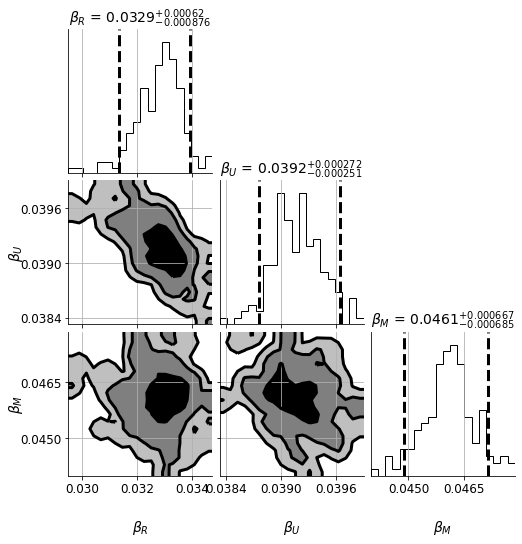

In [12]:
from covid19model.optimization.run_optimization import samples_dict_to_emcee_chain # used for corner plots
import json
import corner

# All necessary information to make a corner plot is in the samples_dict dictionary
# Based on Notebooks/calibration/emcee-manual-thinning
fig_path = f'../../results/calibrations/COVID19_SEIRD/arr/'
signature = 'local-run_init-DATA_100xPSO_1000xMCMC'
spatial_unit = signature + "_first"
run_date = '2021-05-01'
filename = 'local-run_init-DATA_100xPSO_1000xMCMC_first_BETAs-prelockdown_2021-05-01.json'
samples_dict = json.load(open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{filename}'))

parNames_mcmc = ['beta_R', 'beta_U', 'beta_M']
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$']
nwalkers=36
discard=0
thin=50

samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)
# for control of labelsize of x,y-ticks:
# ticks=[[0,0.50,0.10],[0,1,2],[0,4,8,12],[0,4,8,12],[0,1,2],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1]],
for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
fig.savefig(fig_path+'cornerplots/'+spatial_unit+'_CORNER_BETAs-prelockdown_'+run_date+'.pdf', dpi=400, bbox_inches='tight')
# plt.close()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


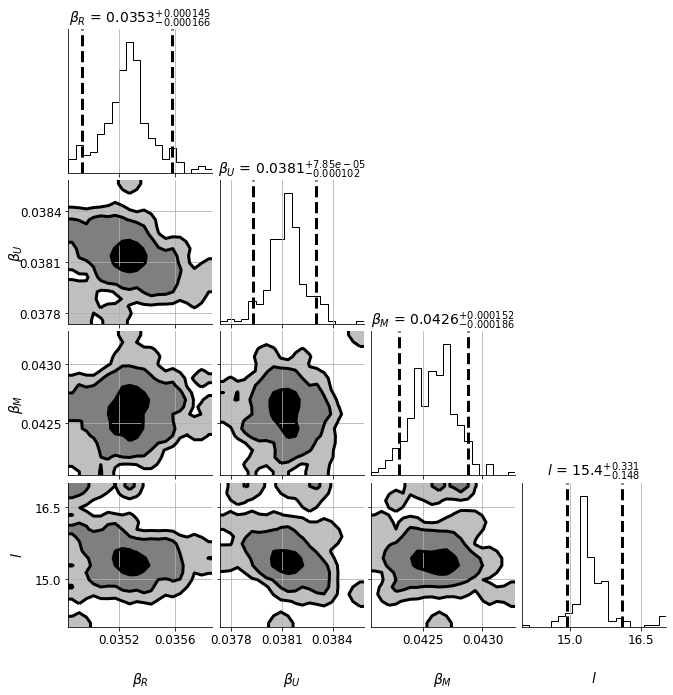

In [13]:
from covid19model.optimization.run_optimization import samples_dict_to_emcee_chain # used for corner plots
import json
import corner

# All necessary information to make a corner plot is in the samples_dict dictionary
# Based on Notebooks/calibration/emcee-manual-thinning
fig_path = f'../../results/calibrations/COVID19_SEIRD/arr/'
signature = 'local-run_init-DATA_100xPSO_1000xMCMC'
spatial_unit = signature + "_second"
run_date = '2021-05-01'
filename = 'local-run_init-DATA_100xPSO_1000xMCMC_second_BETAs_comp_postlockdown_2021-05-01.json'
samples_dict = json.load(open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{filename}'))

parNames_mcmc = ['beta_R', 'beta_U', 'beta_M', 'l']
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$', '$l$']
nwalkers=36
discard=0
thin=50

samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)
# for control of labelsize of x,y-ticks:
# ticks=[[0,0.50,0.10],[0,1,2],[0,4,8,12],[0,4,8,12],[0,1,2],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1]],
for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
fig.savefig(fig_path+'cornerplots/'+spatial_unit+'_CORNER_BETAs_comp_postlockdown_'+run_date+'.pdf', dpi=400, bbox_inches='tight')
# plt.close()